New red QSO Code

In [17]:
#imports placed here
import os
import pickle 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

found file 39627770262716602, but pickle is missing
found file 39627800436540700, but pickle is missing
found file 39627811958295714, but pickle is missing
found file 39633127710134030, but pickle is missing
The mean reduced chi squared is 1.606455193236715 with a standard deviation 0.6588730079484685


(array([ 2., 11., 25., 37., 27., 24.,  5.,  4.,  2.,  1.]),
 array([0.   , 0.402, 0.804, 1.206, 1.608, 2.01 , 2.412, 2.814, 3.216,
        3.618, 4.02 ]),
 <BarContainer object of 10 artists>)

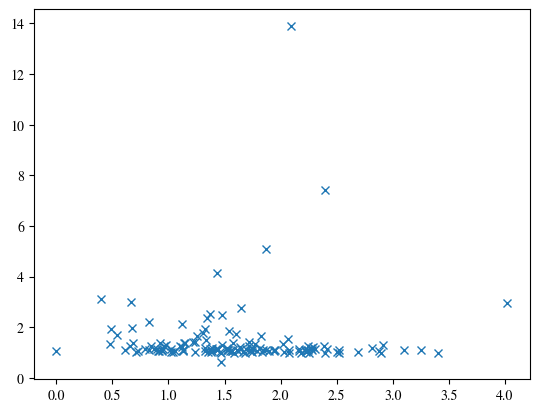

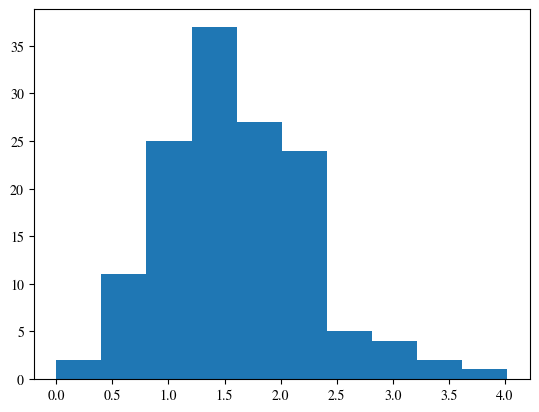

In [18]:
#Here we will inspect the contents of the pickle files for fits which exclude the host component
#first get a list of directory contents and catalogue:
fileAddress = "results/excludinghost"
catalogue = pd.read_csv("data/RedQSOCatalogue.csv")


files = list(os.listdir(fileAddress))
reducedChiSquareds = []
Zs = []
for file in files:
    #check that the file is a directory:
    if "." in file:
        continue
    if os.path.exists(f"{fileAddress}/{file}/fitting_results/{file}-result-band-g.pkl"):
        output = pickle.load(open(f"{fileAddress}/{file}/fitting_results/{file}-result-band-g.pkl","rb"))
        #print(output.final_result_ps)
        #print(output.reduced_Chisq)
        obj_No = list(catalogue["TARGETID"]).index(int(file))
        z = list(catalogue["Z"])[obj_No]

        reducedChiSquareds.append(output.reduced_Chisq)
        Zs.append(z)
    else:
        print(f"found file {file}, but pickle is missing")

#chi2 statistics
print(f"The mean reduced chi squared is {round(np.mean(Zs),3)} with a standard deviation {round(np.std(Zs),3)}")

#displaying plots:
plt.figure()
plt.plot(Zs,reducedChiSquareds,linestyle="None",marker="x")
plt.figure()
plt.hist(Zs)
